---

# SVM with optimized[1] search space


[1] Keerthi, S. S., & Lin, C. J. (2003). Asymptotic behaviors of support vector machines with Gaussian kernel. Neural computation, 15(7), 1667-1689.


### Content

+ [1. Notebook description](#1.-Notebook-Description)
+ [2. Load and Select](#2.-Load-And-Select)
+ [3. Linear Grid Search](#3.-Linear-Grid-Search)
+ [4. RBF Grid Search](#3.-RBF-Grid-Search)
+ [5. Plots](#5.-Plots)


---

# 1. Notebook Description

This notebook demonstrates the example workflow for the search space optimization following Keerthi and Lin.

---

**Imports:**

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [18]:
# digits related code
from digits.data import matimport
from digits.data import select
from digits.metrics.cfm import Confusion, ConfusionGrid
from digits.metrics import scores
from digits.inspect.plot import normhist

# system libraries
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.grid_search import GridSearchCV, ParameterGrid

import matplotlib.pyplot as plt
from matplotlib import rcParams

# 2. Load And Select

In [4]:
imp = matimport.Importer(dataroot='../../../data/thomas/artcorr/')
imp.open('3130.h5')

In [5]:
samples = imp.store.samples
targets = imp.store.targets
samples.shape

(7204, 89664)

In [6]:
samples = select.fromtimerange(samples, 't_0200', 't_0600')
samples, targets = select.fromtargetlist(samples, targets, [1, 8])

In [7]:
mmscaler = MinMaxScaler(feature_range=(-1,1))
split = train_test_split(mmscaler.fit_transform(samples.values), targets.values.flatten(),
                         test_size=0.1, random_state=23)
X_train, X_test, y_train, y_test = split

Let's have a look at the scaler impact for some random sample:

In [19]:
rcParams['figure.figsize'] = (30,4)

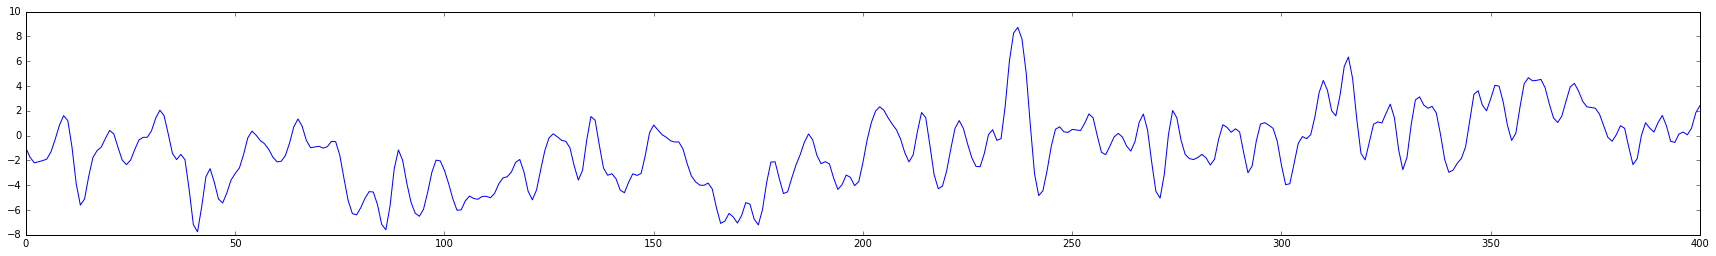

In [22]:
_ = plt.plot(samples.values[0, 0:401])

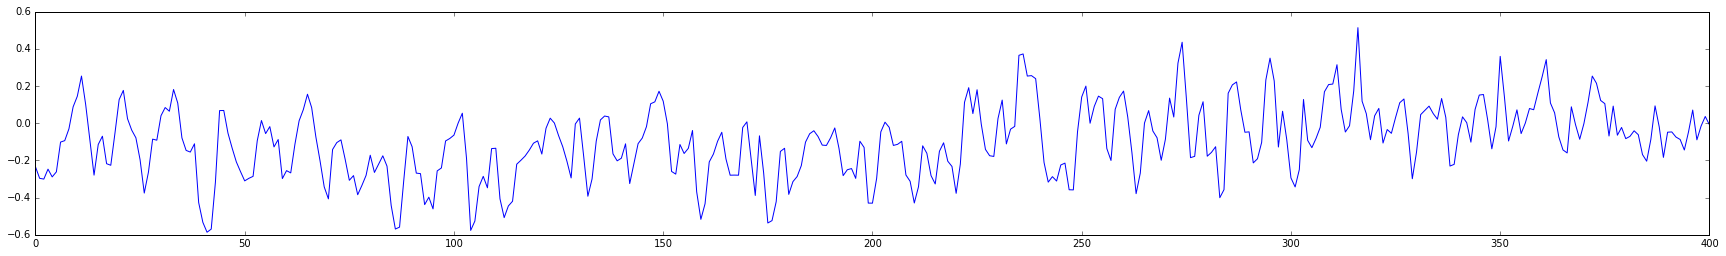

In [23]:
_ = plt.plot(mmscaler.fit_transform(samples.values)[0, 0:401])

# 3. Linear Grid Search

SVM Grid search to find a ballpark of C

Keerthi and Lin propose:  $log(C) = [-8,2]$

In [10]:
params = [
    { 
      'kernel': ['linear'],
      'C': np.logspace(-8,2,10),
    },
]
grid = GridSearchCV(SVC(), params, n_jobs=32, cv=8, verbose=2)
_ = grid.fit(X_train, y_train)
C_lin = grid.best_params_['C']
scores.best_params(grid, 4)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
[CV] C=1e-08, kernel=linear ..........................................
[CV] C=1e-08, kernel=linear ..........................................
[CV] C=1e-08, kernel=linear ..........................................
[CV] C=1e-08, kernel=linear ..........................................
[CV] C=1e-08, kernel=linear ..........................................
[CV] C=1e-08, kernel=linear ..........................................
[CV] C=1e-08, kernel=linear ..........................................
[CV] C=1e-08, kernel=linear ..........................................
[CV] C=1.29154966501e-07, kernel=linear ..............................
[CV] C=1.29154966501e-07, kernel=linear ..............................
[CV] C=1.29154966501e-07, kernel=linear ..............................
[CV] C=1.29154966501e-07, kernel=linear ..............................
[CV] C=1.29154966501e-07, kernel=linear ..............................
[CV] C=1.2915496

[CV] C=100.0, kernel=linear ..........................................
[CV] ..................... C=0.000278255940221, kernel=linear - 1.6min
[CV] C=100.0, kernel=linear ..........................................
[CV] ..................... C=0.000278255940221, kernel=linear - 1.7min
[CV] C=100.0, kernel=linear ..........................................
[CV] ..................... C=0.000278255940221, kernel=linear - 1.7min
[CV] C=100.0, kernel=linear ..........................................
[CV] ..................... C=0.000278255940221, kernel=linear - 1.7min
[CV] C=100.0, kernel=linear ..........................................
[CV] ..................... C=0.000278255940221, kernel=linear - 1.7min
[CV] C=100.0, kernel=linear ..........................................
[CV] ..................... C=0.000278255940221, kernel=linear - 1.7min
[CV] C=100.0, kernel=linear ..........................................
[CV] ....................... C=0.0464158883361, kernel=linear - 1.5min
[CV] .

[Parallel(n_jobs=32)]: Done  58 out of  80 | elapsed:  3.9min remaining:  1.5min


[CV] ........................ C=0.599484250319, kernel=linear - 1.5min
[CV] ....................... C=0.0464158883361, kernel=linear - 1.7min
[CV] ....................... C=0.0464158883361, kernel=linear - 1.7min
[CV] ....................... C=0.0464158883361, kernel=linear - 1.7min
[CV] ......................... C=7.74263682681, kernel=linear -  57.0s
[CV] ......................... C=7.74263682681, kernel=linear -  55.1s
[CV] ......................... C=7.74263682681, kernel=linear - 1.0min
[CV] ......................... C=7.74263682681, kernel=linear - 1.1min
[CV] ......................... C=7.74263682681, kernel=linear - 1.1min
[CV] ......................... C=7.74263682681, kernel=linear - 1.1min
[CV] ................................. C=100.0, kernel=linear -  53.3s
[CV] ......................... C=7.74263682681, kernel=linear - 1.1min
[CV] ......................... C=7.74263682681, kernel=linear - 1.1min
[CV] ................................. C=100.0, kernel=linear - 1.1min
[CV] .

[Parallel(n_jobs=32)]: Done  80 out of  80 | elapsed:  4.7min finished


[mean: 0.79865, std: 0.02261, params: {'kernel': 'linear', 'C': 0.0035938136638046258},
 mean: 0.79715, std: 0.02869, params: {'kernel': 'linear', 'C': 0.046415888336127822},
 mean: 0.79715, std: 0.02869, params: {'kernel': 'linear', 'C': 0.59948425031894215},
 mean: 0.79715, std: 0.02869, params: {'kernel': 'linear', 'C': 7.7426368268112773}]

---

## 4. RBF Grid Search

Gaussian SVM "Grid" search with fixed C

---


In the second step we pick $C,\sigma^{2}$ satisfying the equation

$$log(\sigma^{2}) = log(C) - log(\tilde{C})$$

$$ C = \sigma^{2} \cdot \tilde{C}$$

with $log(\tilde{C})$ from the first (linear) search. Note that SKLearn is using meta parameter $\gamma = \frac{1}{2\sigma^{2}}$.

Keerthi and Lin propose an interval for $log(\sigma{^2})$ of $[-8, 8]$ with a smaller step size:

In [11]:
ssqs = np.logspace(-8,8,20)
Cs = ssqs * C_lin
gammas = 1/(2 * ssqs)

Since $C$ and $\gamma$ are now dependent we are using `zip()` as a simple trick to still use the GridSearchCV interface.

In [12]:
params = [ { 'kernel': ['rbf'], 'C': [c], 'gamma': [gamma]} for c,gamma in zip(Cs, gammas)]
grid = GridSearchCV(SVC(), params, n_jobs=32, cv=10, verbose=1)
_ = grid.fit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed: 10.0min
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed: 12.1min finished


# 4. Plots

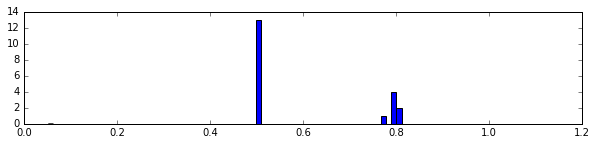

In [24]:
normhist([x[1] for x in grid.grid_scores_])
#plt.savefig('../../3_reports/images/SVM_rbf_single_plain_gridhist_3130.png')
#np.save('SVM_rbf_single_plain_3130.npy', grid)

In [14]:
scores.best_params(grid, 10)

[mean: 0.80992, std: 0.02160, params: {'kernel': 'rbf', 'gamma': 8.1188836959436201e-05, 'C': 22.132437157587177},
 mean: 0.80240, std: 0.02941, params: {'kernel': 'rbf', 'gamma': 1.1678607345450606e-05, 'C': 153.86310873807199},
 mean: 0.79489, std: 0.02394, params: {'kernel': 'rbf', 'gamma': 5.0000000000000001e-09, 'C': 359381.3663804626},
 mean: 0.79414, std: 0.02635, params: {'kernel': 'rbf', 'gamma': 3.4759639808878099e-08, 'C': 51695.208632264308},
 mean: 0.79264, std: 0.02614, params: {'kernel': 'rbf', 'gamma': 2.4164651192858861e-07, 'C': 7436.0967082087864},
 mean: 0.79189, std: 0.02784, params: {'kernel': 'rbf', 'gamma': 1.6799091431418939e-06, 'C': 1069.6452479219208},
 mean: 0.77010, std: 0.02960, params: {'kernel': 'rbf', 'gamma': 0.00056441894584234641, 'C': 3.1836401756864929},
 mean: 0.50413, std: 0.00111, params: {'kernel': 'rbf', 'gamma': 50000000.0, 'C': 3.5938136638046261e-11},
 mean: 0.50413, std: 0.00111, params: {'kernel': 'rbf', 'gamma': 7192249.4414383145, 'C':

RBF is not improving accuracy at all ($\gamma \rightarrow 0$ is basically linear SVM), probably due to the large number of features.

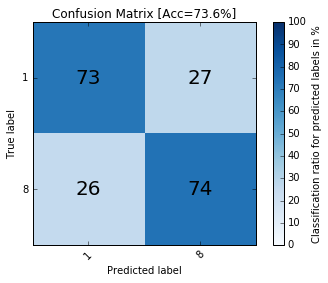

In [15]:
Confusion(grid, X_test, y_test).plot()
#Confusion(grid, X_test, y_test).plot(save_file='../../3_reports/images/SVM_rbf_single_plain_3130.png')

In [16]:
grid.score(X_test, y_test)

0.73648648648648651

---